<a href="https://colab.research.google.com/github/christopher-reed/tidytuesday/blob/master/week_22/TidyTuesday_Mario_Cart_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-25/records.csv')

df.head()

,track,type,shortcut,player,system_played,date,time_period,time,record_duration
0,Luigi Raceway,Three Lap,No,Salam,NTSC,1997-02-15,2M 12.99S,132.99,1
1,Luigi Raceway,Three Lap,No,Booth,NTSC,1997-02-16,2M 9.99S,129.99,0
2,Luigi Raceway,Three Lap,No,Salam,NTSC,1997-02-16,2M 8.99S,128.99,12
3,Luigi Raceway,Three Lap,No,Salam,NTSC,1997-02-28,2M 6.99S,126.99,7
4,Luigi Raceway,Three Lap,No,Gregg G,NTSC,1997-03-07,2M 4.51S,124.51,54


# Cleaning

In [3]:
# Three lap records only
df_clean = df[df['type'] == 'Three Lap']

# Get the fastest records for each three lap course
# Do this by sorting greatest to least first, then taking the first row in each group
df_clean_fastest_records = (df_clean.
 sort_values(by = ['track', 'shortcut', 'time']).
 groupby(['track', 'shortcut']).
 head(1))

# Some track don't have a short cut (boo). Remove them!
courses_with_shortcuts = (df_clean_fastest_records.
 groupby('track').
 count().
 reset_index())

# Type == 2 bc we grouped and counted
courses_with_shortcuts = courses_with_shortcuts[courses_with_shortcuts ['type'] == 2]['track'].to_list()

# Filter using the above list
df_clean_fastest_records_shortcut = df_clean_fastest_records[df_clean_fastest_records['track'].isin(courses_with_shortcuts)]

# Find difference between shortcut and non-shortcut time
# Use pivot_tabl() to go from long --> wide format
df_time_dif = (df_clean_fastest_records_shortcut.
               pivot_table(index = 'track', columns = 'shortcut', values = 'time').
               reset_index())

# Subtract times
df_time_dif['time_dif'] = df_time_dif['No'] - df_time_dif['Yes']

# Order from most to least effective
df_time_dif = (df_time_dif.
               sort_values(by = 'time_dif',
                          ascending = True).
               reset_index(drop = True))

# Add a mid-way point for plotting
df_time_dif['midpoint'] = (df_time_dif['No'] + df_time_dif['Yes'])/ 2

# Formatted track names
df_time_dif['formatted_track'] = df_time_dif['track'].str.replace(' ', '\n')

# Handle DK seperatly bc 3 words and too lazy to make function (:
df_time_dif['formatted_track'] = df_time_dif['formatted_track'].replace({"D.K.'s\nJungle\nParkway":"D.K.'s Jungle\nParkway"})

# Inspect (ignore funky index)
df_time_dif

shortcut,track,No,Yes,time_dif,midpoint,formatted_track
0,Kalimari Desert,123.94,121.92,2.02,122.930,Kalimari\nDesert
1,Sherbet Land,115.15,91.65,23.50,103.400,Sherbet\nLand
2,Mario Raceway,87.51,58.49,29.02,73.000,Mario\nRaceway
3,Royal Raceway,171.25,119.49,51.76,145.370,Royal\nRaceway
4,Yoshi Valley,102.13,33.35,68.78,67.740,Yoshi\nValley
5,Luigi Raceway,117.77,25.30,92.47,71.535,Luigi\nRaceway
6,Frappe Snowland,119.95,23.61,96.34,71.780,Frappe\nSnowland
7,Choco Mountain,115.93,17.29,98.64,66.610,Choco\nMountain
8,D.K.'s Jungle Parkway,131.62,21.35,110.27,76.485,D.K.'s Jungle\nParkway
9,Toad's Turnpike,177.80,30.31,147.49,104.055,Toad's\nTurnpike


# Plotting

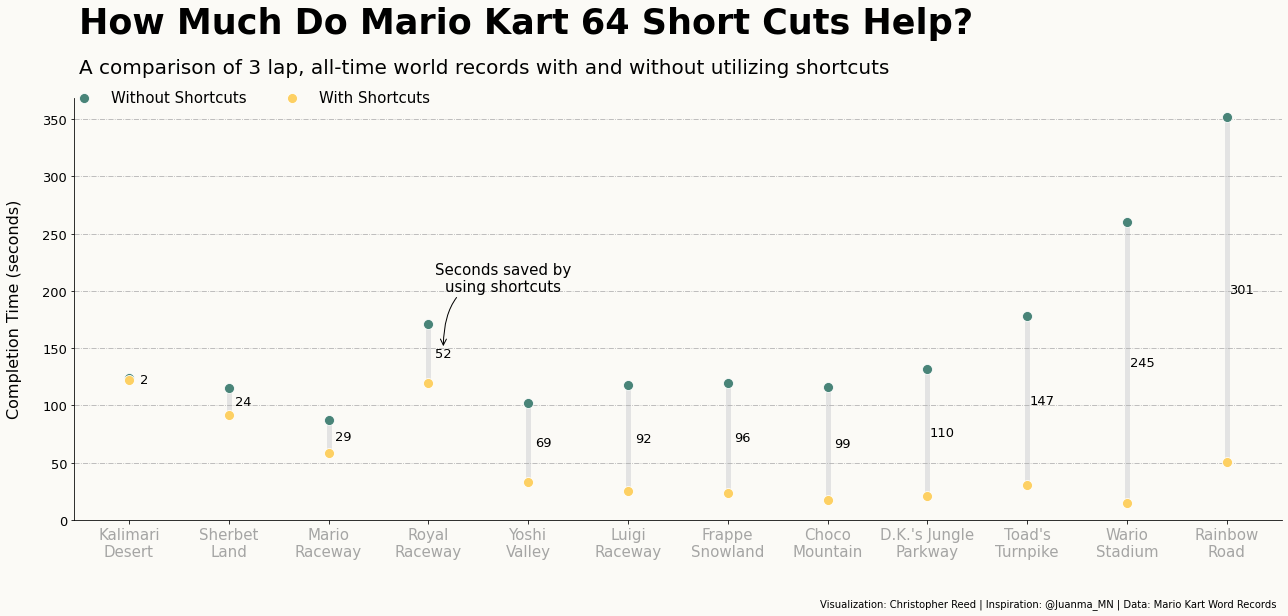

In [26]:
# Create fig and ax
fig, ax = plt.subplots(figsize = (18, 9))

#################
## DEFINE DATA ##
#################

ranks = df_time_dif.index.to_list()
x_coords = list(zip(df_time_dif['Yes'], df_time_dif['No']))
line_midpoint = df_time_dif['midpoint'].to_list()
time_difference = [str(round(x)) for x in df_time_dif['time_dif'].to_list()]
track_names = df_time_dif['formatted_track'].to_list()

#################
## MAIN FIGURE ##
#################

sns.scatterplot(x = df_time_dif.index, y = 'No', data = df_time_dif, zorder = 5, color = '#498478', label = 'Without Shortcuts', s = 100)
sns.scatterplot(x = df_time_dif.index, y = 'Yes', data = df_time_dif, zorder = 5, color = '#fdd063', label = 'With Shortcuts', s = 100)

# Y-coordinate pairs
x_coords = list(zip(df_time_dif['Yes'], df_time_dif['No']))

for i in ranks:

  ax.plot([i,i], x_coords[i], zorder = -1, color = '#e3e3e3', linewidth = 5)

  ax.text(y = line_midpoint[i], x = i + 0.15,
          s = time_difference[i],
          fontsize = 13,
          ha = 'center',
          va = 'center')

#######################
## TITLES AND LABELS ##
#######################

ax.text(x = -0.5, y = 425,
        s = 'How Much Do Mario Kart 64 Short Cuts Help?',
        fontsize = 35,
        weight = 'bold')

ax.text(x = -0.5, y = 390,
        s = 'A comparison of 3 lap, all-time world records with and without utilizing shortcuts  ',
        fontsize = 20)

ax.set_ylabel('Completion Time (seconds)',
              fontsize = 16,
              labelpad = 20)

##########
## GRID ##
##########

ax.grid(axis = 'y', ls = '-.')

####################
## TICKS AND AXES ##
####################

ax.set_xticks(ranks)
ax.set_xticklabels(track_names, fontsize = 15, color = '#a5a5a4')

ax.tick_params(axis = 'y', labelsize = 13)

ax.set_ylim(bottom = 0)

#################
## ANNOTATIONS ##
#################

ax.annotate("Seconds saved by\nusing shortcuts",
            fontsize = 15,
            ha = 'center',
            xy=(3.15, 150), xycoords='data',
            xytext=(3.75, 200), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=90"))


#######################
## BACKGROUND COLORS ##
#######################

ax.set_facecolor('#fbfaf6')
fig.set_facecolor('#fbfaf6')

#############
## CREDITS ##
#############

ax.text(x = np.max(ranks) + 0.5, y = -75,
        s = 'Visualization: Christopher Reed | Inspiration: @Juanma_MN | Data: Mario Kart Word Records',
        ha = 'right')

plt.legend(ncol = 2, prop = {'size':15}, frameon = False, loc = 'upper left', bbox_to_anchor = (-.015, 1.05), labelspacing = 0)

###################
## ODDS AND ENDS ##
###################

# Despine
ax = sns.despine()

# Tight
plt.tight_layout()

############
## SAVING ##
############

filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.savefig('/content/drive/MyDrive/TidyTuesday/Mario Cart Records/Images/' + filename, facecolor = '#fbfaf6', bbox_inches = 'tight')
plt.savefig('Mario Kart Recods Low Res', facecolor = '#fbfaf6', bbox_inches = 'tight')

# Making of GIF

In [ ]:
import imageio
import os

images = []
for filename in os.listdir('/content/drive/MyDrive/TidyTuesday/Mario Cart Records/Images'):
    images.append(imageio.imread('/content/drive/MyDrive/TidyTuesday/Mario Cart Records/Images/' + filename))

imageio.mimsave('Mario Cart Records: Making Of.gif', images, duration = 0.33)